<a href="https://colab.research.google.com/github/oyankhan/demo/blob/main/model_training_for_Leaf_Nafis_iqbal_khan_research_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

IMAGE_SIZE = 224
BATCH_SIZE = 32

dataset_path = '/content/drive/My Drive/Leaf'

image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, file))

            label = os.path.basename(root)
            labels.append(label)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print("Total images found:", len(image_paths))
print("Classes:", le.classes_)

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_encoded))

def load_image(path, label):
    path = tf.cast(path, tf.string)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label

dataset = dataset.map(load_image).shuffle(200).batch(BATCH_SIZE)


Total images found: 2213
Classes: ['Bitter Gourd Cercospora Leaf' 'Bitter Gourd Downy Mildew Leaf'
 'Bitter Gourd Healthy Leaf' 'Healthy Malabar Spinach Leaf'
 'Healthy Pumpkin Leaf' 'Healthy Sweet Potato Leaf' 'HealthyTaro Leaf'
 'Malabar Spinach Anthracnose Leaf' 'Malabar Spinach Cercospora Spot'
 'Malabar Spinach Downy Mildew Leaf' 'Malabar Spinach Straw Mite'
 'Pumpkin Bacterial leaf spot' 'Pumpkin Downy mildew'
 'Pumpkin Gummy stem blight' 'Pumpkin Leaf Cercospora Spot'
 'Pumpkin Powdery mildew' 'Sweet Potato Leaf Blight'
 'Sweet Potato Leaf Fusarium Wilt' 'Sweet Potato Leaf Virus Attack'
 'Taro Leaf blight' 'Taro Mosaic Virus' 'taro fungus']


In [ ]:
!ls "/content/drive/My Drive/Leaf"


'Bitter Gourd Leaf'  'Pumpkin Leaf'	  'Taro Leaf'
'Malabar Spinach'    'Sweet Potato Leaf'


In [ ]:
class_names = le.classes_
class_names


array(['Bitter Gourd Cercospora Leaf', 'Bitter Gourd Downy Mildew Leaf',
       'Bitter Gourd Healthy Leaf', 'Healthy Malabar Spinach Leaf',
       'Healthy Pumpkin Leaf', 'Healthy Sweet Potato Leaf',
       'HealthyTaro Leaf', 'Malabar Spinach Anthracnose Leaf',
       'Malabar Spinach Cercospora Spot',
       'Malabar Spinach Downy Mildew Leaf', 'Malabar Spinach Straw Mite',
       'Pumpkin Bacterial leaf spot', 'Pumpkin Downy mildew',
       'Pumpkin Gummy stem blight', 'Pumpkin Leaf Cercospora Spot',
       'Pumpkin Powdery mildew', 'Sweet Potato Leaf Blight',
       'Sweet Potato Leaf Fusarium Wilt',
       'Sweet Potato Leaf Virus Attack', 'Taro Leaf blight',
       'Taro Mosaic Virus', 'taro fungus'], dtype='<U33')

Batch shape: (32, 224, 224, 3)
Labels: [ 3  3 10  3  3 10 10  3  3  3  3 10  9  9  3  3 10  9  9  3  9 10  3  3
 10 10  3  3  9  9  3  3]


<Figure size 1000x1000 with 0 Axes>

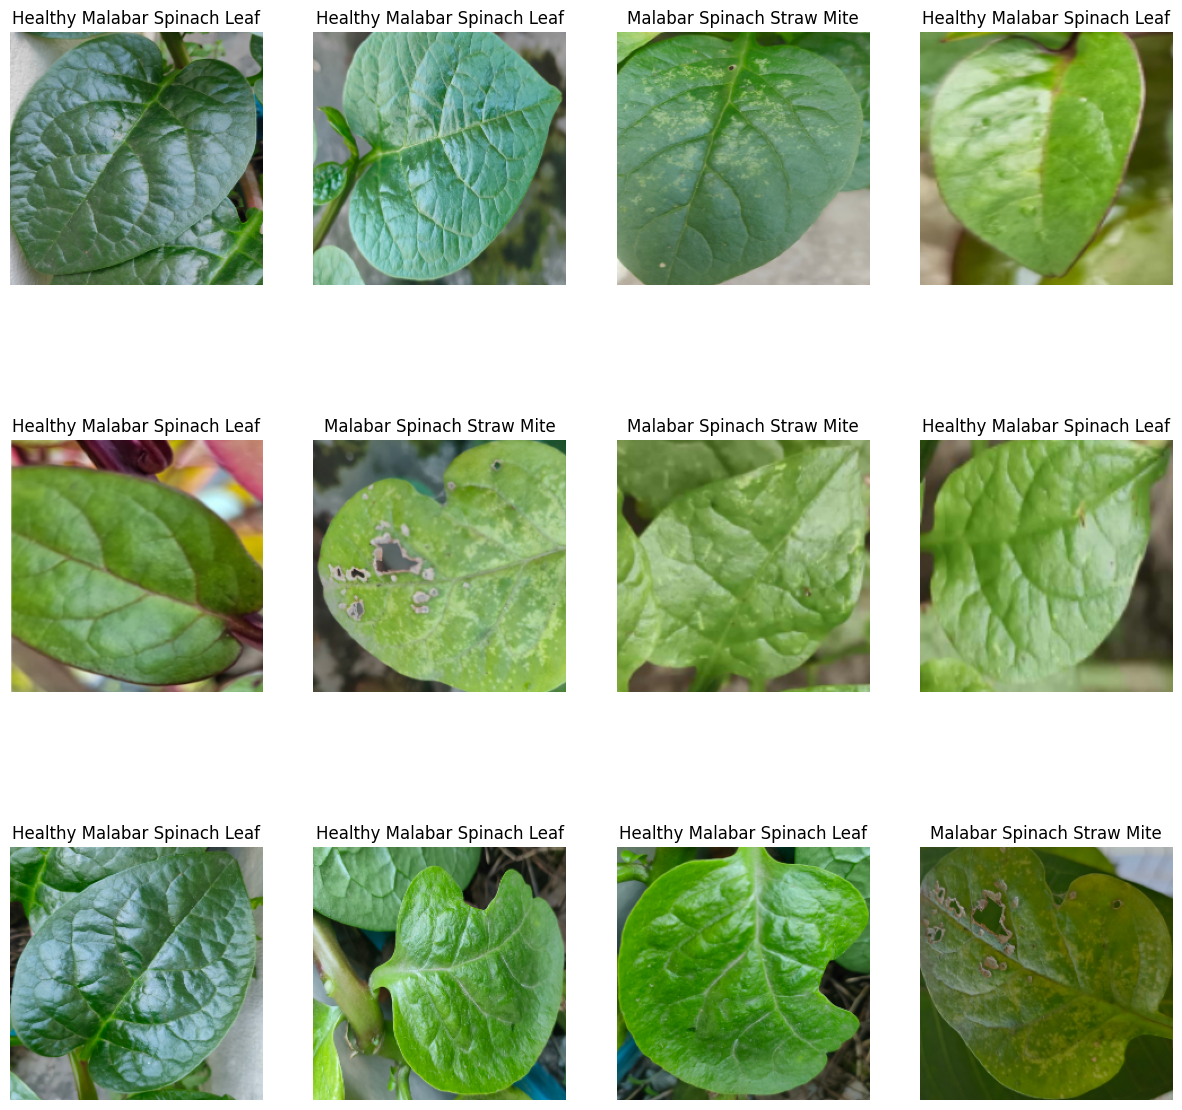

In [ ]:

plt.figure(figsize=(10,10))
import textwrap

plt.figure(figsize=(15,15))
for image_batch, labels_batch in dataset.take(1):
    print("Batch shape:", image_batch.shape)
    print("Labels:", labels_batch.numpy())

    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i].numpy()])
        plt.axis("off")


In [ ]:
import math

train_size = 0.8
num_images = len(image_paths)
train_count = math.floor(num_images * train_size)
test_count = num_images - train_count

print("Total images:", num_images)
print("Train images:", train_count)
print("Test images:", test_count)

Total images: 2213
Train images: 1770
Test images: 443


In [ ]:

num_images = len(image_paths)
train_size = 0.8
val_size = 0.1

train_count = math.floor(num_images * train_size)
val_count = math.floor(num_images * val_size)
test_count = num_images - train_count - val_count

print("Train:", train_count)
print("Validation:", val_count)
print("Test:", test_count)


Train: 1770
Validation: 221
Test: 222


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size   = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])


In [ ]:


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 23

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
conv_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,135 (914.59 KB)

 Trainable params: 234,135 (914.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
test_size = sum(1 for _ in test_ds)
print("Number of test batches:", test_size)

Number of test batches: 7


In [ ]:
def dataset_summary(ds, name="Dataset"):
    total_images = 0
    batch_num = 0

    for batch_images, _ in ds:
        batch_num += 1
        total_images += batch_images.shape[0]

    print(f"{name} Summary:")
    print(f"Total batches: {batch_num}")
    print(f"Total images: {total_images}\n")



In [ ]:
dataset_summary(train_ds, "Train Dataset")
dataset_summary(val_ds, "Validation Dataset")
dataset_summary(test_ds, "Test Dataset")


Train Dataset Summary:
Total batches: 56
Total images: 1765

Validation Dataset Summary:
Total batches: 7
Total images: 224

Test Dataset Summary:
Total batches: 7
Total images: 224



In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.0895 - loss: 3.0314 - val_accuracy: 0.0938 - val_loss: 2.8422
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.1332 - loss: 2.8126 - val_accuracy: 0.2679 - val_loss: 2.5167
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.1433 - loss: 2.6156 - val_accuracy: 0.2277 - val_loss: 2.7794
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.1568 - loss: 2.6701 - val_accuracy: 0.1429 - val_loss: 2.4985
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.2175 - loss: 2.4887 - val_accuracy: 0.1652 - val_loss: 2.5519
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.1711 - loss: 2.6897 - val_accuracy: 0.3348 - val_loss: 2.3249
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.2143 - loss: 2.3814 - val_accuracy: 0.2902 - val_loss: 2.2691
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.2404 - loss: 2.3734 - val_accuracy: 0.2411 - v

In [ ]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6565 - loss: 1.0040
Test Loss: 1.0939
Test Accuracy: 66.07%


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Final Training Accuracy:", acc[-1])  #jodi training accuracy >> validation accuracy → overfitting.
print("Final Validation Accuracy:", val_acc[-1])  #Jodi training loss << validation loss → overfitting.


Final Training Accuracy: 0.6985835433006287
Final Validation Accuracy: 0.75


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

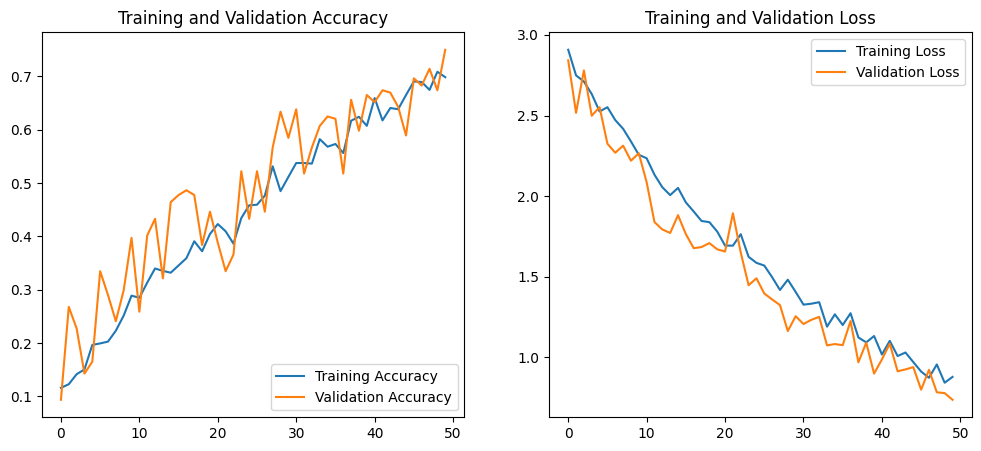

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


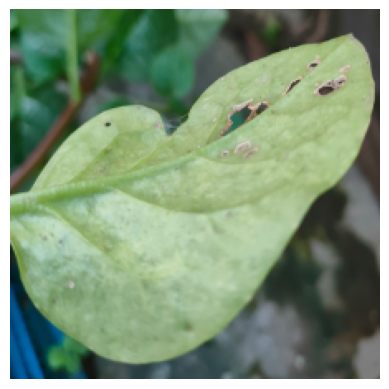

Actual Label: Malabar Spinach Cercospora Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
Predicted Label: Malabar Spinach Cercospora Spot


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    rand_index = random.randint(0, len(images_batch) - 1)
    first_image = images_batch[rand_index].numpy().astype("uint8")

    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    actual_label = class_names[labels_batch[rand_index].numpy()]
    print("Actual Label:", actual_label)

    batch_prediction = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[rand_index])]
    print("Predicted Label:", predicted_label)


In [ ]:
def predict(model, img, image_size=IMAGE_SIZE):

    img = tf.image.resize(img, [image_size, image_size])

    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


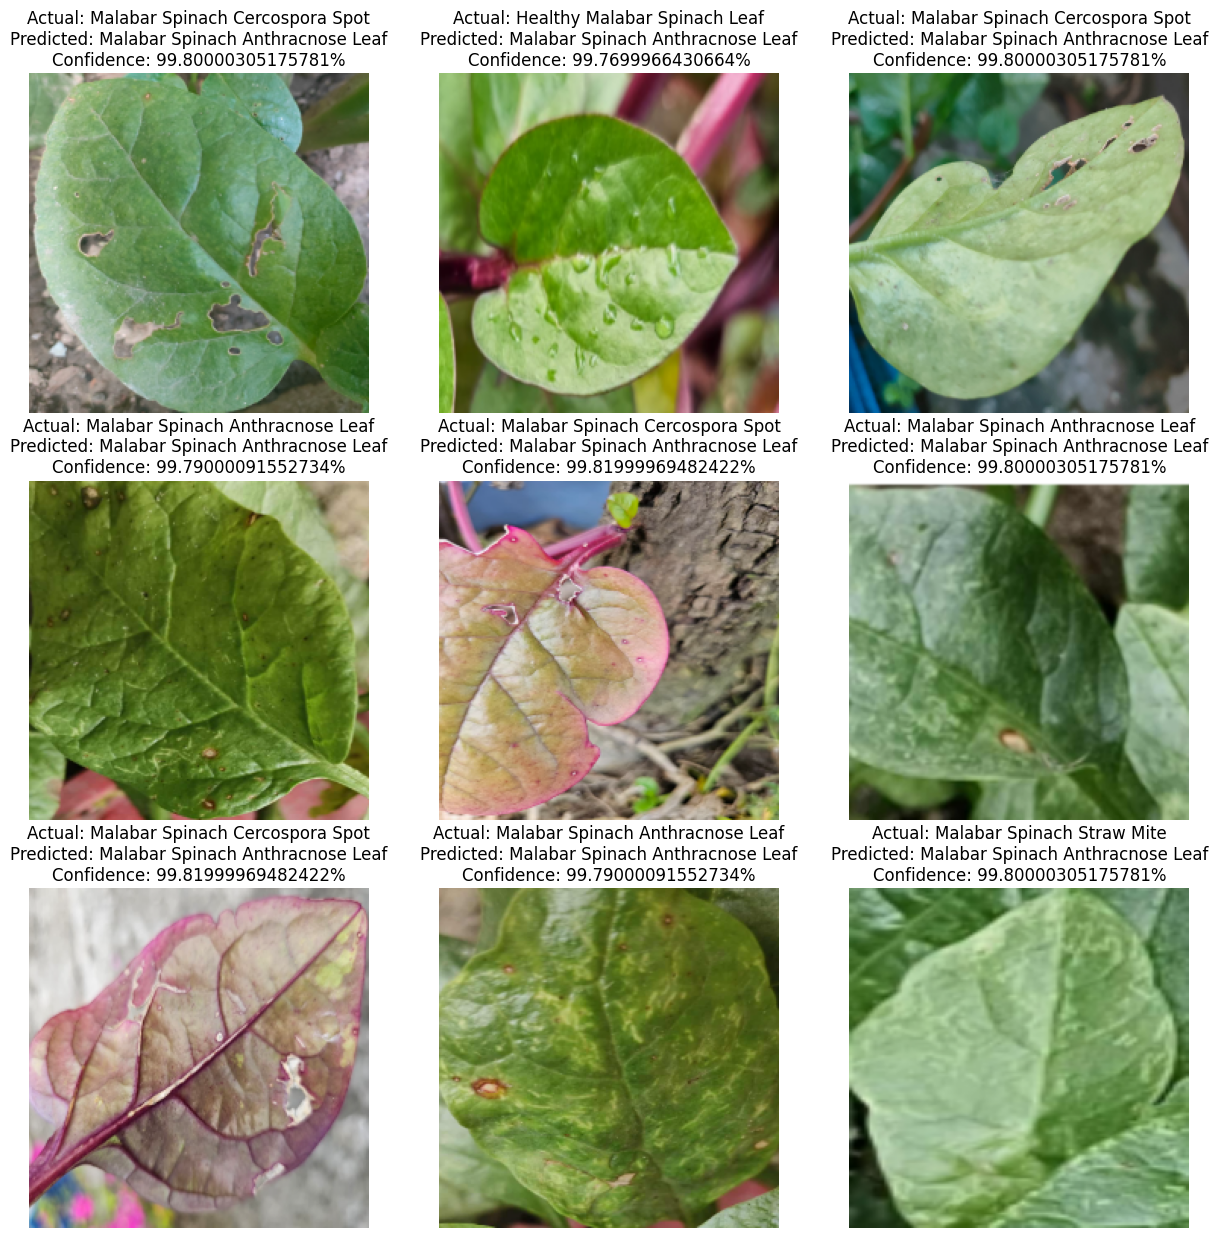

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        img = images[i]
        plt.imshow(img.numpy().astype("uint8"))

        predicted_class, confidence = predict(model, img)
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_true,
    y_pred,
    labels=range(len(class_names)),
    target_names=class_names
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 988ms/step
                                   precision    recall  f1-score   support

     Bitter Gourd Cercospora Leaf       1.00      1.00      1.00         1
   Bitter Gourd Downy Mildew Leaf       0.50      1.00      0.67         1
        Bitter Gourd Healthy Leaf       0.00      0.00      0.00         0
     Healthy Malabar Spinach Leaf       0.46      0.60      0.52        10
             Healthy Pumpkin Leaf       0.15      0.40      0.22         5
        Healthy Sweet Potato Leaf       0.00      0.00      0.00         0
                 HealthyTaro Leaf       0.50      0.25      0.33         4
 Malabar Spinach Anthracnose Leaf       0.57      0.57      0.57        28
  Malabar Spinach Cercospora Spot       0.88      0.79      0.83        73
Malabar Spinach Downy Mildew Leaf       0.50      0.50      0.50         6
       Malabar Spinach Straw Mite       0.43      0.27      0.33        11
      Pumpkin Bacterial leaf spot       0.56      0.56      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  1  0  1  0  0  1  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  2  0  1  0  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  1  1  0  0  0  0  1  0  0  0]
 [ 0  0  1  1  1  0 16  6  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0 11 58  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  3  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  1  0  0  0  0  3  0  0  1  0  1  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  0  5  0  0  1  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  0 24  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  1  0  0  0  2  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  

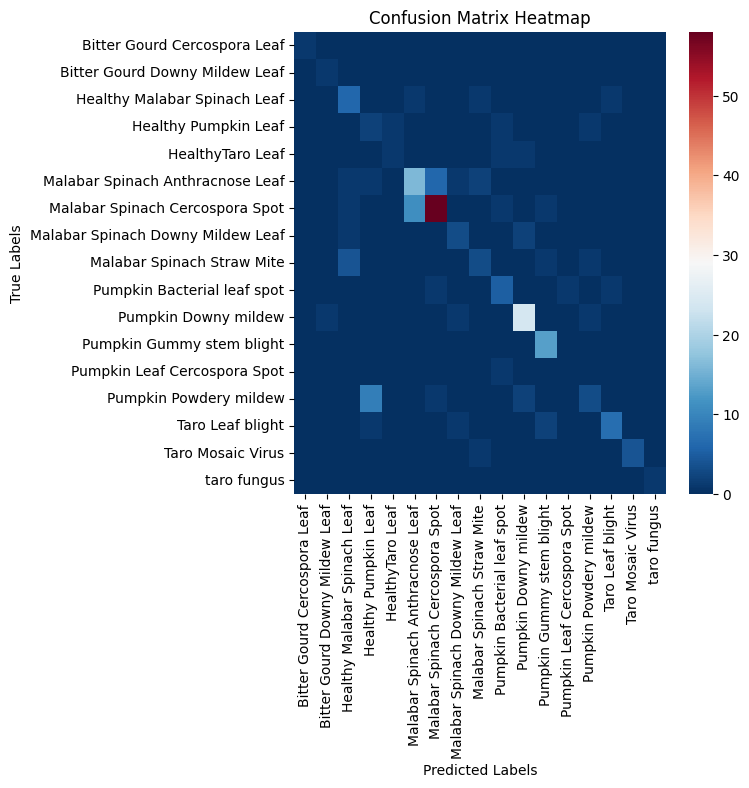

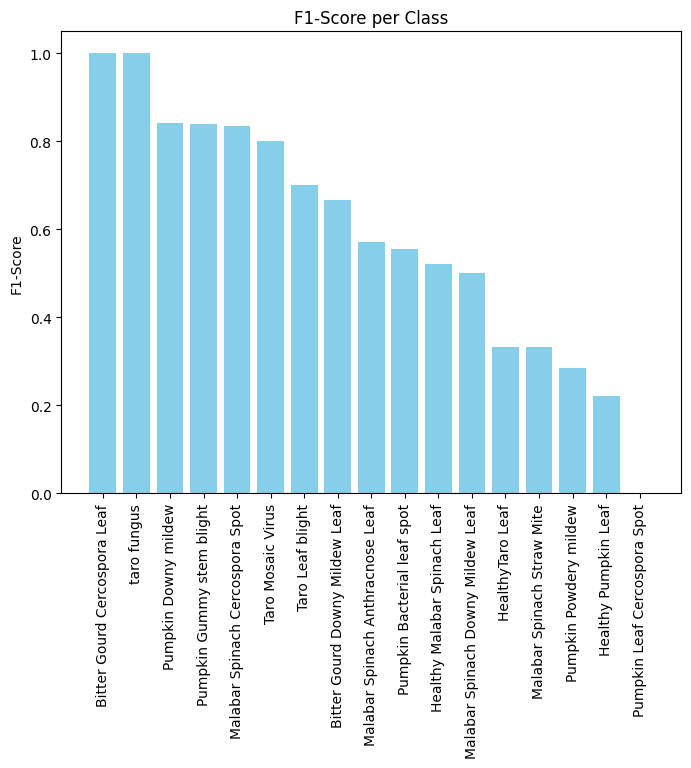

                                Class  Precision    Recall  F1-Score
0        Bitter Gourd Cercospora Leaf   1.000000  1.000000  1.000000
16                        taro fungus   1.000000  1.000000  1.000000
10               Pumpkin Downy mildew   0.827586  0.857143  0.842105
11          Pumpkin Gummy stem blight   0.764706  0.928571  0.838710
6     Malabar Spinach Cercospora Spot   0.878788  0.794521  0.834532
15                  Taro Mosaic Virus   1.000000  0.666667  0.800000
14                   Taro Leaf blight   0.777778  0.636364  0.700000
1      Bitter Gourd Downy Mildew Leaf   0.500000  1.000000  0.666667
5    Malabar Spinach Anthracnose Leaf   0.571429  0.571429  0.571429
9         Pumpkin Bacterial leaf spot   0.555556  0.555556  0.555556
2        Healthy Malabar Spinach Leaf   0.461538  0.600000  0.521739
7   Malabar Spinach Downy Mildew Leaf   0.500000  0.500000  0.500000
4                    HealthyTaro Leaf   0.500000  0.250000  0.333333
8          Malabar Spinach Straw M

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

y_true = np.array(y_true)
y_pred = np.array(y_pred)

unique_labels = np.unique(y_true)


filtered_class_names = [class_names[i] for i in unique_labels]

cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=False, cmap="RdBu_r",
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=unique_labels, zero_division=0)

results_df = pd.DataFrame({
    'Class': filtered_class_names,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1
})


results_df = results_df.sort_values(by='F1-Score', ascending=False)

plt.figure(figsize=(8, 6))
plt.bar(results_df['Class'], results_df['F1-Score'], color='skyblue')
plt.xticks(rotation=90)
plt.title("F1-Score per Class")
plt.ylabel("F1-Score")
plt.show()

print(results_df)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")


Overall Accuracy: 0.6607
Weighted Precision: 0.7084
Weighted Recall: 0.6607
Weighted F1-score: 0.6742


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

unique_labels = np.unique(np.concatenate([y_true, y_pred]))

target_names = [class_names[i] for i in unique_labels]

report = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()
display(df_report)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score     support
Bitter Gourd Cercospora Leaf        1.000000  1.000000  1.000000    1.000000
Bitter Gourd Downy Mildew Leaf      0.500000  1.000000  0.666667    1.000000
Healthy Malabar Spinach Leaf        0.461538  0.600000  0.521739   10.000000
Healthy Pumpkin Leaf                0.153846  0.400000  0.222222    5.000000
Healthy Sweet Potato Leaf           0.000000  0.000000  0.000000    0.000000
HealthyTaro Leaf                    0.500000  0.250000  0.333333    4.000000
Malabar Spinach Anthracnose Leaf    0.571429  0.571429  0.571429   28.000000
Malabar Spinach Cercospora Spot     0.878788  0.794521  0.834532   73.000000
Malabar Spinach Downy Mildew Leaf   0.500000  0.500000  0.500000    6.000000
Malabar Spinach Straw Mite          0.428571  0.272727  0.333333   11.000000
Pumpkin Bacterial leaf spot         0.555556  0.555556  0.555556    9.000000
Pumpkin Downy mildew                0.827586  0.857143  0.842105   28.000000
Pumpkin Gummy stem blight           0.764706  0.928571  0.838710   14.000000
Pumpkin Leaf Cercospora Spot        0.000000  0.000000  0.000000    1.000000
Pumpkin Powdery mildew              0.500000  0.200000  0.285714   15.000000
Sweet Potato Leaf Blight            0.000000  0.000000  0.000000    0.000000
Sweet Potato Leaf Virus Attack      0.000000  0.000000  0.000000    0.000000
Taro Leaf blight                    0.777778  0.636364  0.700000   11.000000
Taro Mosaic Virus                   1.000000  0.666667  0.800000    6.000000
taro fungus                         1.000000  1.000000  1.000000    1.000000
accuracy                            0.660714  0.660714  0.660714    0.660714
macro avg                           0.520990  0.511649  0.500267  224.000000
weighted avg                        0.708412  0.660714  0.674208  224.000000

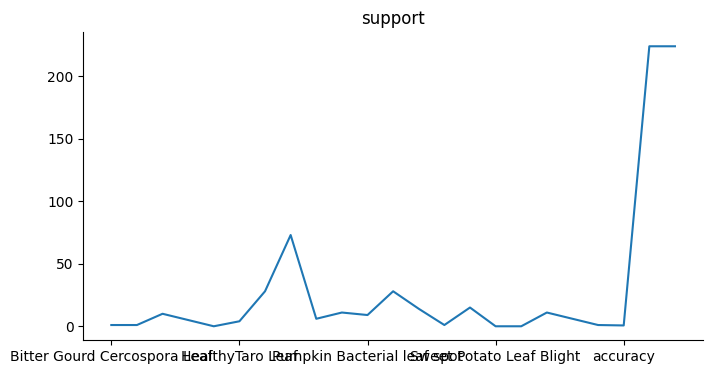

In [ ]:
from matplotlib import pyplot as plt
df_report['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

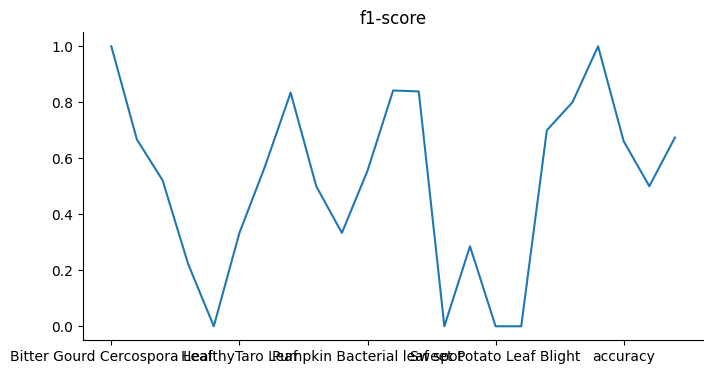

In [ ]:
from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

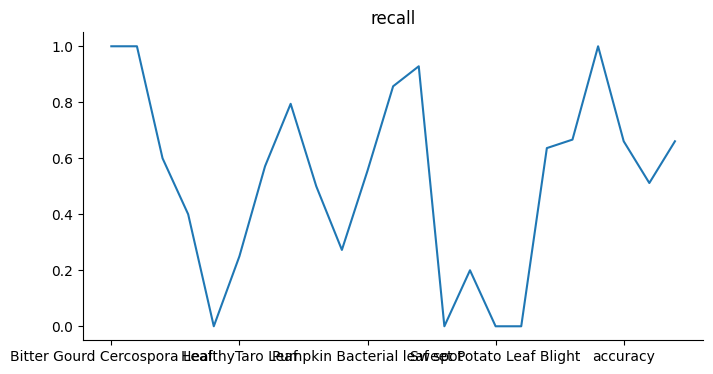

In [ ]:
from matplotlib import pyplot as plt
df_report['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

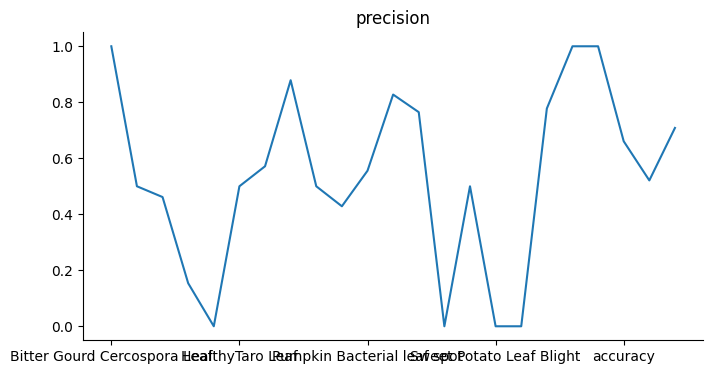

In [ ]:
from matplotlib import pyplot as plt
df_report['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

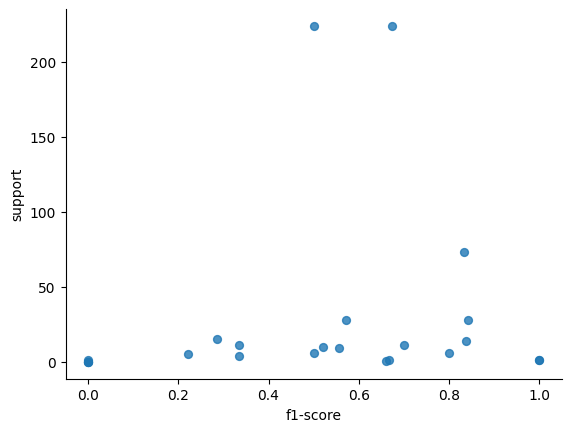

In [ ]:
from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

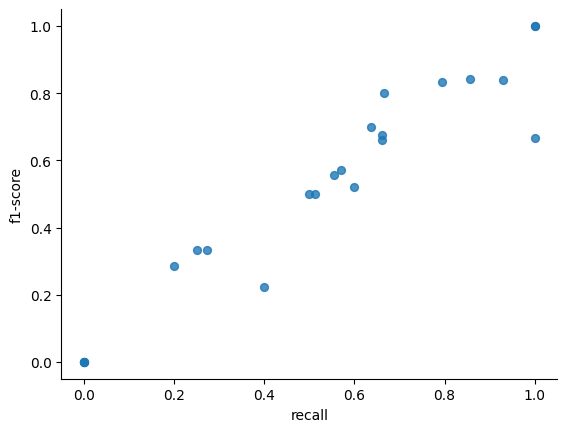

In [ ]:
from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

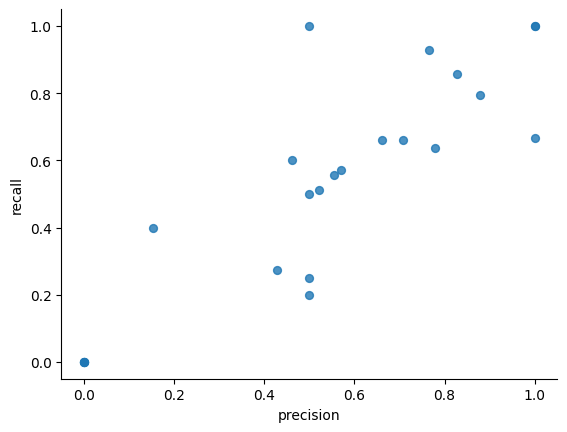

In [ ]:
from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

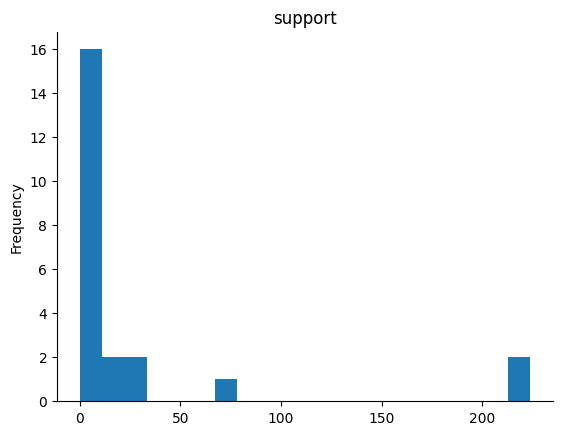

In [ ]:
from matplotlib import pyplot as plt
df_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

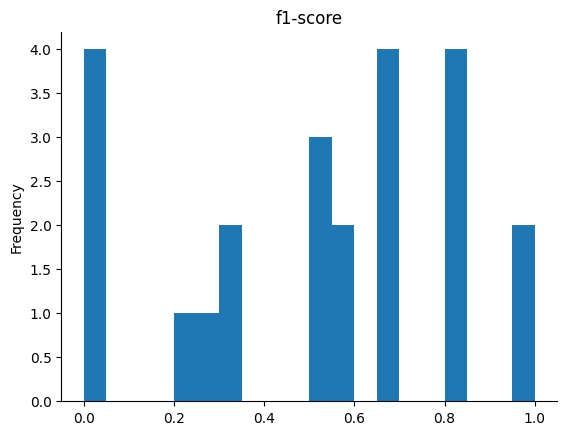

In [ ]:
from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

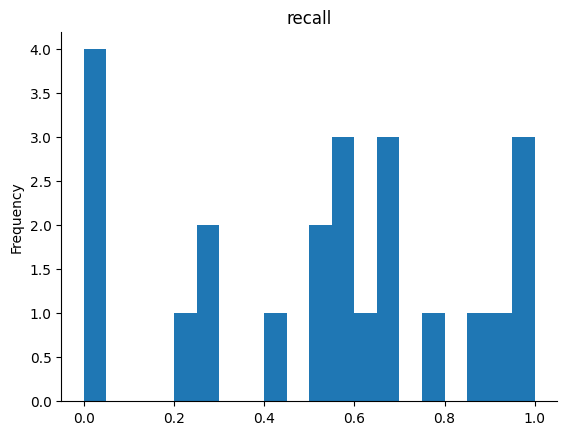

In [ ]:
from matplotlib import pyplot as plt
df_report['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

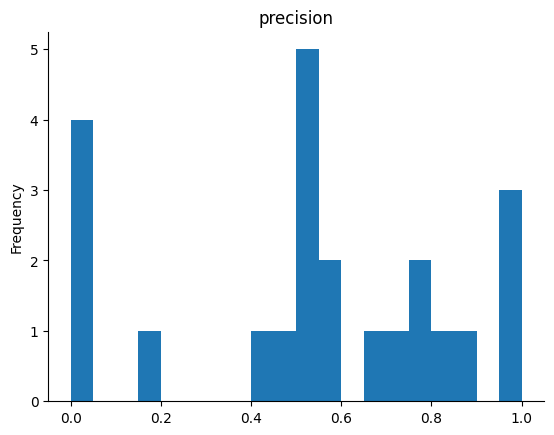

In [ ]:
from matplotlib import pyplot as plt
df_report['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

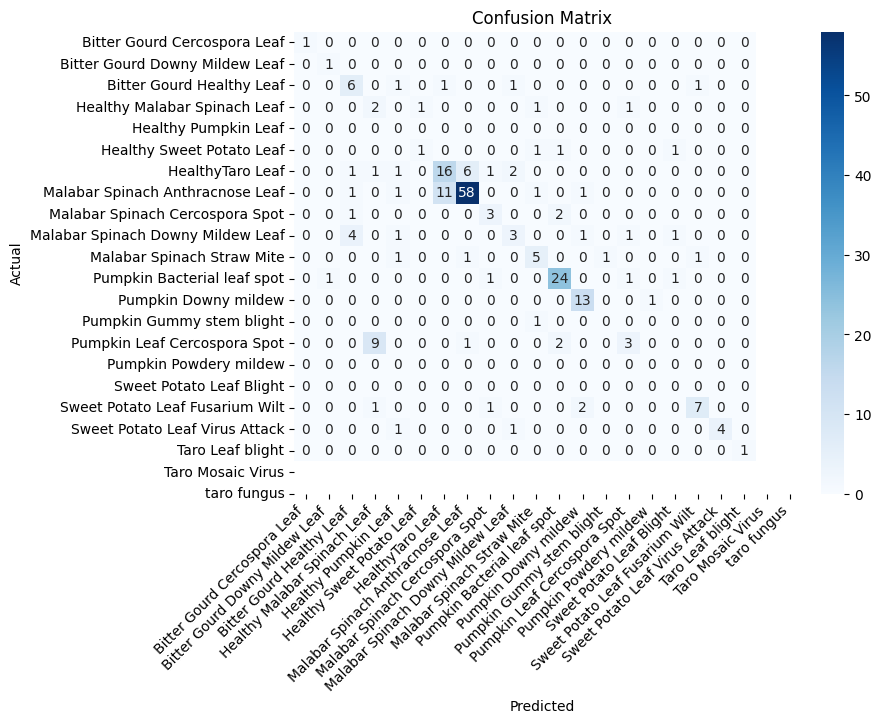

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [ ]:

# ResNet50 Transfer Learning


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt


IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
n_classes = len(class_names)


def preprocess_ds(ds):
    return ds.map(lambda x, y: (preprocess_input(tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))), y))

train_ds_proc = preprocess_ds(train_ds).prefetch(tf.data.AUTOTUNE)
val_ds_proc = preprocess_ds(val_ds).prefetch(tf.data.AUTOTUNE)
test_ds_proc = preprocess_ds(test_ds).prefetch(tf.data.AUTOTUNE)


base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = resnet_model.fit(
    train_ds_proc,
    validation_data=val_ds_proc,
    epochs=EPOCHS
)


scores = resnet_model.evaluate(test_ds_proc)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 387s 7s/step - accuracy: 0.2435 - loss: 3.1000 - val_accuracy: 0.6696 - val_loss: 0.9271
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 376s 7s/step - accuracy: 0.6185 - loss: 1.0876 - val_accuracy: 0.8571 - val_loss: 0.4969
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - accuracy: 0.7498 - loss: 0.7469 - val_accuracy: 0.7679 - val_loss: 0.5586
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 415s 7s/step - accuracy: 0.7600 - loss: 0.7002 - val_accuracy: 0.8884 - val_loss: 0.3383
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 408s 7s/step - accuracy: 0.8478 - loss: 0.4291 - val_accuracy: 0.9062 - val_loss: 0.2751
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.8811 - loss: 0.3659 - val_accuracy: 0.9375 - val_loss: 0.2204
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.8889 - loss: 0.3280 - val_accuracy: 0.9554 - val_loss: 0.1870
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 407s 7s/step - accuracy: 0.9256 - loss: 0.2510 - val_accuracy: 0.8080 - v

In [ ]:
import numpy as np

unique_preds = np.unique(y_pred)
print("Unique predicted classes:", unique_preds)
print("Number of unique predicted classes:", len(unique_preds))


Unique predicted classes: [ 0  1  3  4  6  7  8  9 10 11 12 13 14 15 19 20 21]
Number of unique predicted classes: 17


In [ ]:
unique_true = np.unique(y_true)
print("Unique true classes:", unique_true)
print("Number of unique true classes:", len(unique_true))


Unique true classes: [ 0  1  3  4  6  7  8  9 10 11 12 13 14 15 19 20 21]
Number of unique true classes: 17



Detailed Classification Report:
                                   precision    recall  f1-score   support

     Bitter Gourd Cercospora Leaf       1.00      1.00      1.00         1
   Bitter Gourd Downy Mildew Leaf       1.00      1.00      1.00         1
     Healthy Malabar Spinach Leaf       1.00      0.90      0.95        10
             Healthy Pumpkin Leaf       0.83      1.00      0.91         5
                 HealthyTaro Leaf       1.00      1.00      1.00         4
 Malabar Spinach Anthracnose Leaf       0.93      0.96      0.95        28
  Malabar Spinach Cercospora Spot       0.97      1.00      0.99        73
Malabar Spinach Downy Mildew Leaf       1.00      0.83      0.91         6
       Malabar Spinach Straw Mite       0.90      0.82      0.86        11
      Pumpkin Bacterial leaf spot       0.80      0.89      0.84         9
             Pumpkin Downy mildew       0.96      0.96      0.96        28
        Pumpkin Gummy stem blight       1.00      1.00      1.00  

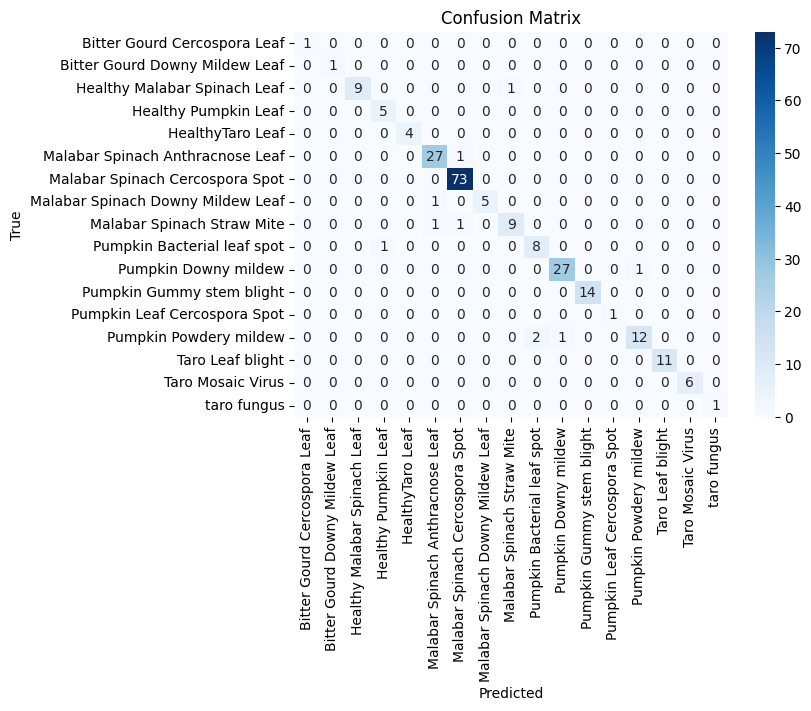

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


labels_present = sorted(np.unique(np.concatenate([y_true, y_pred])))

report = classification_report(
    y_true,
    y_pred,
    labels=labels_present,
    target_names=[class_names[i] for i in labels_present],
    zero_division=0
)

print("\nDetailed Classification Report:")
print(report)


cm = confusion_matrix(y_true, y_pred, labels=labels_present)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in labels_present],
            yticklabels=[class_names[i] for i in labels_present])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


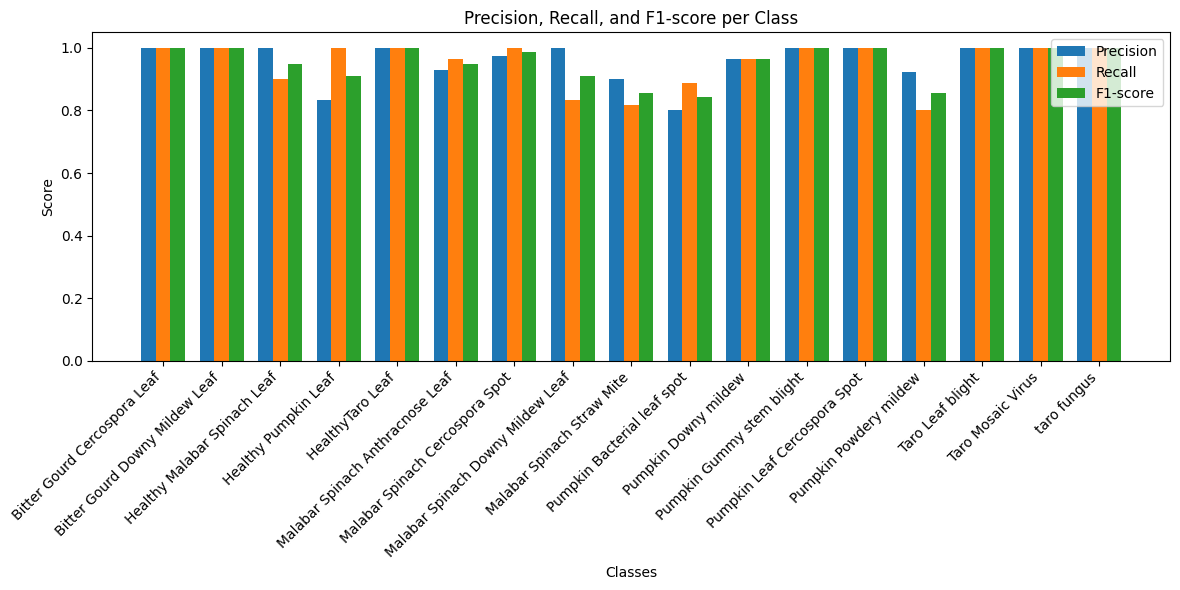

In [ ]:

plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(class_metrics))

plt.bar(x - bar_width, class_metrics['precision'], bar_width, label='Precision')
plt.bar(x, class_metrics['recall'], bar_width, label='Recall')
plt.bar(x + bar_width, class_metrics['f1-score'], bar_width, label='F1-score')

plt.xticks(x, class_metrics.index, rotation=45, ha='right')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score per Class')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2494695562.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=precision_df, x='Class', y='Precision', palette='Blues_d')


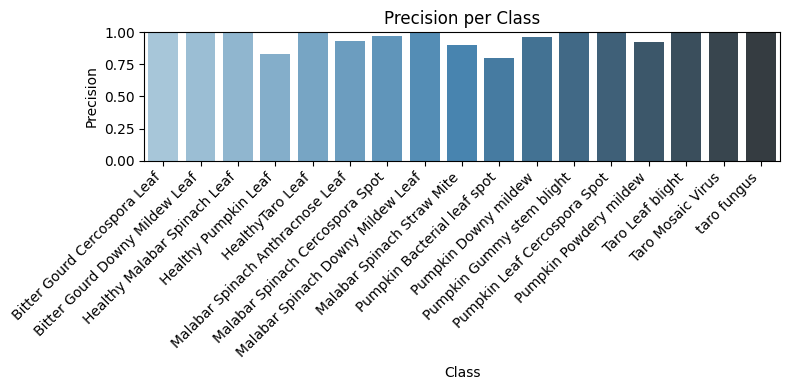

📋 Precision Table:


Class  Precision
0        Bitter Gourd Cercospora Leaf   1.000000
1      Bitter Gourd Downy Mildew Leaf   1.000000
2        Healthy Malabar Spinach Leaf   1.000000
3                Healthy Pumpkin Leaf   0.833333
4                    HealthyTaro Leaf   1.000000
5    Malabar Spinach Anthracnose Leaf   0.931034
6     Malabar Spinach Cercospora Spot   0.973333
7   Malabar Spinach Downy Mildew Leaf   1.000000
8          Malabar Spinach Straw Mite   0.900000
9         Pumpkin Bacterial leaf spot   0.800000
10               Pumpkin Downy mildew   0.964286
11          Pumpkin Gummy stem blight   1.000000
12       Pumpkin Leaf Cercospora Spot   1.000000
13             Pumpkin Powdery mildew   0.923077
14                   Taro Leaf blight   1.000000
15                  Taro Mosaic Virus   1.000000
16                        taro fungus   1.000000

In [ ]:
# --- Precision Table ---
precision_df = class_metrics[['precision']].reset_index()
precision_df.columns = ['Class', 'Precision']

plt.figure(figsize=(8, 4))
sns.barplot(data=precision_df, x='Class', y='Precision', palette='Blues_d')
plt.title('Precision per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


precision_table = class_metrics[['precision']].reset_index()
precision_table.columns = ['Class', 'Precision']
print("📋 Precision Table:")
display(precision_table)

/tmp/ipython-input-1356376930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recall_df, x='Class', y='Recall', palette='Oranges_d')


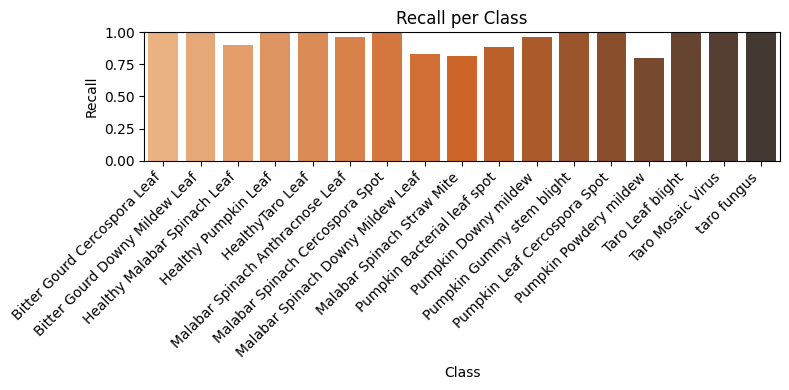


📋 Recall Table:


Class    Recall
0        Bitter Gourd Cercospora Leaf  1.000000
1      Bitter Gourd Downy Mildew Leaf  1.000000
2        Healthy Malabar Spinach Leaf  0.900000
3                Healthy Pumpkin Leaf  1.000000
4                    HealthyTaro Leaf  1.000000
5    Malabar Spinach Anthracnose Leaf  0.964286
6     Malabar Spinach Cercospora Spot  1.000000
7   Malabar Spinach Downy Mildew Leaf  0.833333
8          Malabar Spinach Straw Mite  0.818182
9         Pumpkin Bacterial leaf spot  0.888889
10               Pumpkin Downy mildew  0.964286
11          Pumpkin Gummy stem blight  1.000000
12       Pumpkin Leaf Cercospora Spot  1.000000
13             Pumpkin Powdery mildew  0.800000
14                   Taro Leaf blight  1.000000
15                  Taro Mosaic Virus  1.000000
16                        taro fungus  1.000000

In [ ]:
# --- Recall Table ---
recall_df = class_metrics[['recall']].reset_index()
recall_df.columns = ['Class', 'Recall']

plt.figure(figsize=(8, 4))
sns.barplot(data=recall_df, x='Class', y='Recall', palette='Oranges_d')
plt.title('Recall per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


recall_table = class_metrics[['recall']].reset_index()
recall_table.columns = ['Class', 'Recall']
print("\n📋 Recall Table:")
display(recall_table)

/tmp/ipython-input-3902966171.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f1_df, x='Class', y='F1-score', palette='Purples_d')


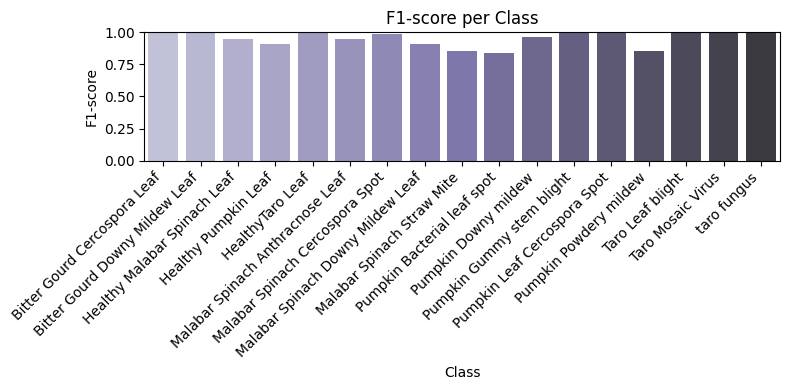


📋 F1-score Table:


Class  F1-score
0        Bitter Gourd Cercospora Leaf  1.000000
1      Bitter Gourd Downy Mildew Leaf  1.000000
2        Healthy Malabar Spinach Leaf  0.947368
3                Healthy Pumpkin Leaf  0.909091
4                    HealthyTaro Leaf  1.000000
5    Malabar Spinach Anthracnose Leaf  0.947368
6     Malabar Spinach Cercospora Spot  0.986486
7   Malabar Spinach Downy Mildew Leaf  0.909091
8          Malabar Spinach Straw Mite  0.857143
9         Pumpkin Bacterial leaf spot  0.842105
10               Pumpkin Downy mildew  0.964286
11          Pumpkin Gummy stem blight  1.000000
12       Pumpkin Leaf Cercospora Spot  1.000000
13             Pumpkin Powdery mildew  0.857143
14                   Taro Leaf blight  1.000000
15                  Taro Mosaic Virus  1.000000
16                        taro fungus  1.000000

In [ ]:
# --- F1-score Table ---
f1_df = class_metrics[['f1-score']].reset_index()
f1_df.columns = ['Class', 'F1-score']

plt.figure(figsize=(8, 4))
sns.barplot(data=f1_df, x='Class', y='F1-score', palette='Purples_d')
plt.title('F1-score per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



f1_table = class_metrics[['f1-score']].reset_index()
f1_table.columns = ['Class', 'F1-score']
print("\n📋 F1-score Table:")
display(f1_table)